# Grab some ibl data and ceed it

NOTE: really need to check insertion vs session info, could be multiple insertions on top of each other

Note: to extract spikes - stream raw ephys data and use spike time and channel info to collect spike 
    waveforms!

In [1]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

from brainbox.io.one import SpikeSortingLoader

import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesResampler
import torch
from tqdm import tqdm
import pandas as pd


/home/noah/mambaforge/envs/ceed2/lib/python3.10/site-packages/ibllib/io/raw_data_loaders.py:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version


In [2]:
subject_id = 'UCLA006' 
# subject_id = 'PL016'


ins = one.search(subject=subject_id)
eid = ins[0]
eid

'19e66dc9-bf9f-430b-9d6a-acfa85de6fb7'

In [3]:
collections = one.list_collections(eid)
print(collections)
#is there a way to list files in a collection??

['alf/probe00/pykilosort', 'alf', 'raw_ephys_data/probe00', 'alf/probe00', 'raw_ephys_data']


In [4]:
file = '_phy_spikes_subset.waveforms.npy'
file = 'clusters.waveforms.npy'
# file = 'templates.waveforms.npy' #templates for each unit, very similar to clusters.waveforms
# file = 'spikes.amps'
file2 = 'spikes.clusters'
file3 = 'clusters.depths'
file4 = 'clusters.channels'
file5 = 'clusters.metrics'
file6 = 'clusters.peakToTrough'

spike_waveforms = one.load_dataset(eid, file, collection='alf/probe00/pykilosort')
clusters = one.load_dataset(eid, file2, collection='alf/probe00/pykilosort')
depths = one.load_dataset(eid, file3, collection='alf/probe00/pykilosort')
channels = one.load_dataset(eid, file4, collection='alf/probe00/pykilosort')
metrics = one.load_dataset(eid, file5, collection='alf/probe00/pykilosort')
p2T = one.load_dataset(eid, file6, collection='alf/probe00/pykilosort')

#how to get x position here... channels ok?

#need to double check that 1st channel is appropriate

print(spike_waveforms.shape)
#ibl data so probably arranged as (neuron, channels, time)
import numpy as np
print(clusters.shape)
print(depths.shape)
print(channels.shape)
print(np.unique(clusters).shape)

(795, 82, 32)
(20177238,)
(795,)
(795,)
(795,)


In [5]:
# clusters[0:100]

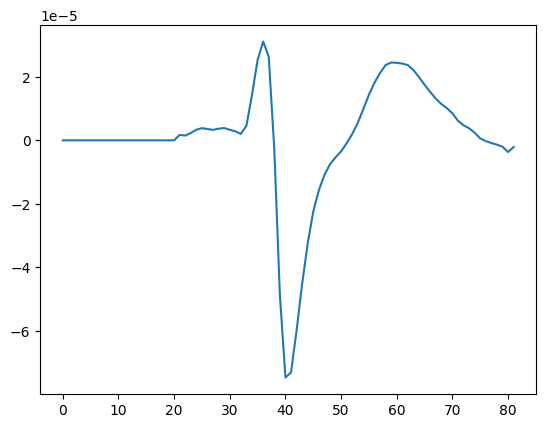

In [6]:
plt.plot(spike_waveforms[3][:,0])
#spikes are all at sample 42
plt.show()

In [7]:
# #Code stolen from Han 
# from tslearn.preprocessing import TimeSeriesResampler

# #upsample data for our model
# spikes_test_wavemap_up = []
# plot = True
# for spike in spike_waveforms: #take only the 1st channel
#     # plt.plot(spike, alpha=.1, color='black')
#     spike_up = TimeSeriesResampler(sz=121).fit_transform(spike[None,:])
#     spikes_test_wavemap_up.append(spike_up[0,:,0])
#     # if plot:
#     #     plt.plot(spike_up[0,:,0], alpha=.1, color='black')
# spikes_test_wavemap_up = np.asarray(spikes_test_wavemap_up)

In [8]:
# plt.plot(spikes_test_wavemap_up[3])
# #spikes are all at sample 42 (before upsampling)
# plt.show()

In [9]:
def normalize_wf(wf):
    """Normalize waveform for use in cell type experiments.
    Parameters
    ----------
    wf: numpy.ndarray
        spike that has shape (n_chans, spike_length_samples)
    Returns
    -------
    waveform normalized to the range [0, 1] to retain shape information, but not amplitude information
    """
    if len(wf.shape) == 1:
        _ = wf.shape
        n_chans = None
    else:
        n_chans, _ = wf.shape
    wf = wf.flatten()
    if np.max(np.abs(wf),axis=0) != 0:
        wf /= np.max(np.abs(wf),axis=0)
    wf = wf.reshape(n_chans, -1) if n_chans is not None else wf
    return wf

In [10]:
# from sklearn.preprocessing import Normalizer as normalizer
# normalize_wf = normalizer().fit_transform

In [11]:
# norm = normalize_wf(spikes_test_wavemap_up[3])
# shifted = shift_wf(norm)
# plt.plot(norm)
# #spikes are all at sample 42
# plt.show()
# # plt.plot(shifted)
# # plt.show()

In [12]:
#apply to all data
#upsample and normalize data
def ceed_preprocess(dataset):

    #should accept single channrel and multichannel data, takes first channel for multichannel datasets
    if len(dataset.shape) != 2:
        try:
            dataset = dataset[:,:,0]
        except Exception as e:
            print("dataset dimension error")
            print(e)
    
    spikes_upsampled = [TimeSeriesResampler(sz=121).fit_transform(spike)[0][:,0] for spike in dataset]
    # norm_spikes = [normalizer().fit_transform([spike]) for spike in spikes_upsampled]
    norm_spikes = [normalize_wf(spike) for spike in spikes_upsampled] 
    
    return np.asarray(norm_spikes)

waveforms_ceed_formatted = ceed_preprocess(spike_waveforms)

In [13]:
# waveforms_ceed_formatted[0][0]

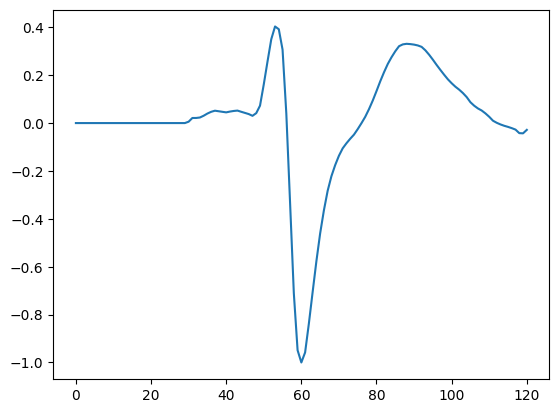

In [14]:
plt.plot(waveforms_ceed_formatted[3])
plt.show()

## ceed time

In [15]:
print(torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name(0))

True 0 NVIDIA GeForce GTX TITAN X


In [16]:
from ceed.models.ceed import CEED

celltype_ckpt_dir = '/home/noah/code/400neur_200s_5d_celltype_fc_ckpt'

celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5)

celltype_ceed_5d.load(celltype_ckpt_dir)
celltype_ceed_5d.model.to('cuda')

2023-10-10 15:44:59.958642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 15:44:59.958700: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 15:44:59.960403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 15:45:00.110983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 15:45:01.178361: W tensorflow/compiler/

Failed to import IBL packages (brainbox, ibllib, one, brainbox
Failed to import spike-psvae/dartsort functions
Using projector; batchnorm False with depth 3; hidden_dim=512
number of encoder params:  888330
number of transfomer params:  0
number of fcpart params:  620037
number of Proj params:  268293
number of classifier params:  0
loading from previous checkpoint:  /home/noah/code/400neur_200s_5d_celltype_fc_ckpt/test


ModelSimCLR(
  (backbone): FullyConnectedEnc(
    (fcpart): Sequential(
      (0): Linear(in_features=121, out_features=768, bias=True)
      (1): ReLU()
      (2): Linear(in_features=768, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=5, bias=True)
      (7): Projector(
        (proj_block): Sequential(
          (0): Linear(in_features=5, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): ReLU()
          (4): Linear(in_features=512, out_features=5, bias=True)
        )
      )
    )
  )
)

In [17]:
#batch input data
print(waveforms_ceed_formatted.shape)
batchsize = 265 #(largest factor)
cells = waveforms_ceed_formatted.shape[0]
number_of_batches = int(cells/batchsize)
timepoints = waveforms_ceed_formatted.shape[1]


data_tensor = torch.from_numpy(waveforms_ceed_formatted.astype('float32')) #must be float32?
data_tensor = data_tensor.reshape(number_of_batches, batchsize, timepoints)
data_tensor = data_tensor.to('cuda')
print(data_tensor.shape, data_tensor.device)


(795, 121)
torch.Size([3, 265, 121]) cuda:0


In [18]:
# data = torch.unsqueeze(data_tensor[0], dim=-1)
# print(data.shape, data_tensor[0].shape)

In [19]:
embeddings = []
with torch.no_grad():
    for spike in tqdm(data_tensor):
        feature = celltype_ceed_5d.model(spike)
        embeddings.append(feature)
embeddings = torch.concatenate(embeddings).to('cpu').detach().squeeze().numpy()

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]


In [20]:
# embeddings = celltype_ceed_5d.transform(data_tensor)

In [21]:
print(embeddings.shape)

(795, 5)


In [22]:
print(embeddings[0])

[-5.6744785  -3.2041295  -1.1261494  -0.59627193 -5.416833  ]


## Data for each waveform:
    waveform
    channel (x position)
    depth 
    CEED features
    Can also include Firing Rate and p2p (can see if p2p is decodeable from shape)
    

In [23]:
metrics.keys()

Index(['cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB',
       'contamination', 'contamination_alt', 'drift', 'missed_spikes_est',
       'noise_cutoff', 'presence_ratio', 'presence_ratio_std',
       'slidingRP_viol', 'spike_count', 'firing_rate', 'label'],
      dtype='object')

In [24]:
metrics.firing_rate

0       5.933501
1      14.497526
2       0.878818
3       3.098791
4       0.019569
         ...    
790     0.005139
791     0.019569
792     0.060683
793     0.110099
794     0.164852
Name: firing_rate, Length: 795, dtype: float64

In [25]:
#this should be a dataframe for easier manipulation and search...
cell_structure = []
for i, waveform in enumerate(waveforms_ceed_formatted):
    cell = {'waveform' : waveform, 'embeddings':embeddings[i], 'depth' : depths[i], 'channel': channels[i], 
            'firing_rate': metrics.firing_rate[i], 'cluster_id' : metrics.cluster_id[i], 'p2T':p2T[i], 
            'p2p' : np.float32(1000*(metrics.amp_max[i] - metrics.amp_min[i])), 'amps' : 1000*metrics.amp_median[i]}
    cell_structure.append(cell)
    

In [26]:
cell_structure[0].keys()

dict_keys(['waveform', 'embeddings', 'depth', 'channel', 'firing_rate', 'cluster_id', 'p2T', 'p2p', 'amps'])

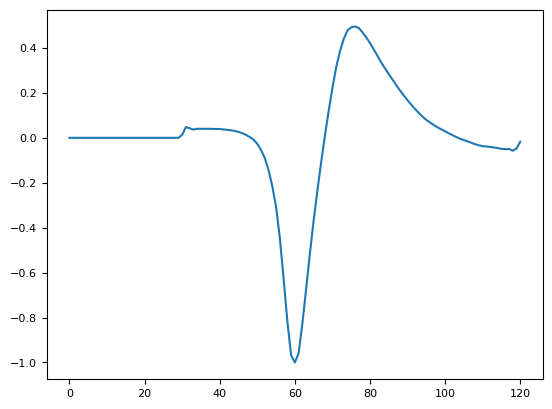

460.0
1.1819077
[-5.110993   -3.760215   -2.1039212   0.20922822 -5.231313  ]


In [27]:
template_id = 89
plt.plot(cell_structure[template_id]['waveform'])
plt.show()
print(cell_structure[template_id]['depth'])
print(cell_structure[template_id]['p2p'])
print(cell_structure[template_id]['embeddings'])


In [28]:
dataframe_cells = pd.DataFrame(cell_structure)

In [29]:
# dataframe_cells.sort_values(by='cluster_id', inplace = True)

In [30]:
dataframe_cells.head()

,waveform,embeddings,depth,channel,firing_rate,cluster_id,p2T,p2p,amps
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.6744785, -3.2041295, -1.1261494, -0.596271...",20.0,0,5.933501,0,0.499997,0.148374,0.105942
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.2820187, -3.3257954, -2.0739157, 0.6581040...",20.0,0,14.497526,1,0.433331,0.170361,0.104917
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.902452, -3.7623112, -1.1823697, -1.106853,...",20.0,0,0.878818,2,0.466664,0.110067,0.109398
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.3847847, -3.169677, -2.0407019, 1.1954426,...",20.0,1,3.098791,3,-0.133333,0.135527,0.104720
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.1969705, -3.08665, -2.157361, 1.1720166, -...",20.0,0,0.019569,4,0.499997,0.044360,0.083868


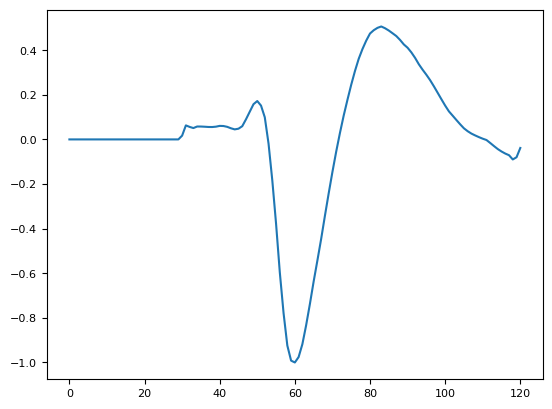

In [55]:
#make a dataset for predicting waveform from embeddings:
dataset = np.array([dataframe_cells['waveform'], dataframe_cells['embeddings']]).T
plt.plot(dataset[0][0])
path = '/home/noah/code/dataset.npy'
# np.save(path, dataset, allow_pickle = True)


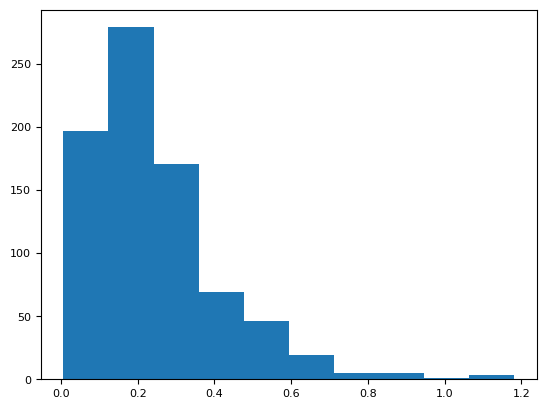

In [31]:
plt.hist(dataframe_cells.p2p)
plt.show()

In [32]:
#can you predict firing rate from waveforms
# https://compgenomr.github.io/book/predicting-continuous-variables-regression-with-machine-learning.html

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = np.stack(dataframe_cells.embeddings.values) #np.stack is necessary - what is pandas doing here? otherwise output is incorrect shape
# X = dataframe_cells.depth.values.reshape(-1, 1)
# X = dataframe_cells.p2p.values.reshape(-1,1)
# y = dataframe_cells.firing_rate.values
# y = dataframe_cells.p2p.values
y = dataframe_cells.p2T.values
# y = dataframe_cells.channel.values
# y = dataframe_cells.cluster_id.values
# y = dataframe_cells.amps.values



print(X.shape)
print(y.shape)
#split earlier so I can keep info about different components used - i.e. waveforms?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

reg = LinearRegression().fit(X_train, y_train)


#need to try and use other regression models, maybe a logistic regression could work too...

(795, 5)
(795,)


In [33]:
peakTrough = dataframe_cells.p2T.values.reshape(-1, 1)
fr = dataframe_cells.firing_rate.values
peakTrough.shape

(795, 1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(peakTrough, fr, test_size=0.01, random_state=42, shuffle=True)
reg2 = LinearRegression().fit(X_train, y_train)

In [35]:
reg2.score(X_train, y_train)

0.000612162364400648

In [43]:
reg.score(X_test, y_test)

ValueError: X has 1 features, but LinearRegression is expecting 5 features as input.

In [ ]:
from sklearn.decomposition import PCA

_pca = PCA(n_components=2)
_pca.fit(X_test)
print('total varience explained by PCs = ', np.sum(_pca.explained_variance_ratio_))
print('variences: ', _pca.explained_variance_ratio_)
print(_pca.singular_values_)

pca_reduced_data = _pca.transform(X_test)

In [ ]:
# import colorcet as cc
# def get_ccolor(k):
#     if k == -1:
#         return "#808080"
#     else:
#         return ccolors[k % len(ccolors)]

# range_=[(int(y*100000)) for y in y_test]
# print(np.max(range_))

# ccolors = cc.fire[0:50]

# colour = [get_ccolor(int(y*100000)) for y in y_test]

In [ ]:
plt.scatter(pca_reduced_data[:,0], pca_reduced_data[:,1], c = [y_test])
# plt.plot(X_train, reg.predict(X_train),color='k')
plt.title('PCA projected CEED Embeddings Coloured by Peak to Trough Duration')
plt.xlabel('PC1 - varience = 0.63')
plt.ylabel('PC2 - varience = 0.30')
plt.show()

In [ ]:
pc_split = pca_reduced_data[:,0]
mask = pc_split>2
len(mask)
# pc11_cluster = pc_split[mask]
# pc11_cluster

In [ ]:
import umap
manifold = umap.UMAP(random_state=42, n_components=2).fit(X_test)
X_reduced = manifold.transform(X_test)
print(X_reduced.shape)

In [ ]:
manifold3d = umap.UMAP(random_state=42, n_components=3).fit(X_test)
X_reduced3d = manifold3d.transform(X_test)
print(X_reduced3d.shape)

In [ ]:
#1d umap
manifold1d = umap.UMAP(random_state=42, n_components=1).fit(X_test)
X_reduced1d = manifold1d.transform(X_test)

In [ ]:
plt.scatter(X_reduced1d, y_test)
plt.plot()

In [ ]:
# colour = [get_ccolor(int(y*100)) for y in y_test]
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = [y_test])
plt.title('Umap projected CEED Embeddings Coloured by Peak to Trough Amplitude')

plt.show()

In [37]:
# separate umap clusters

In [38]:
dataframe_cells.head()

,waveform,embeddings,depth,channel,firing_rate,cluster_id,p2T,p2p,amps
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.6744785, -3.2041295, -1.1261494, -0.596271...",20.0,0,5.933501,0,0.499997,0.148374,0.105942
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.2820187, -3.3257954, -2.0739157, 0.6581040...",20.0,0,14.497526,1,0.433331,0.170361,0.104917
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.902452, -3.7623112, -1.1823697, -1.106853,...",20.0,0,0.878818,2,0.466664,0.110067,0.109398
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.3847847, -3.169677, -2.0407019, 1.1954426,...",20.0,1,3.098791,3,-0.133333,0.135527,0.104720
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.1969705, -3.08665, -2.157361, 1.1720166, -...",20.0,0,0.019569,4,0.499997,0.044360,0.083868


In [39]:
# colorscheme = [dataframe_cells.depth]

NameError: name 'X_reduced3d' is not defined

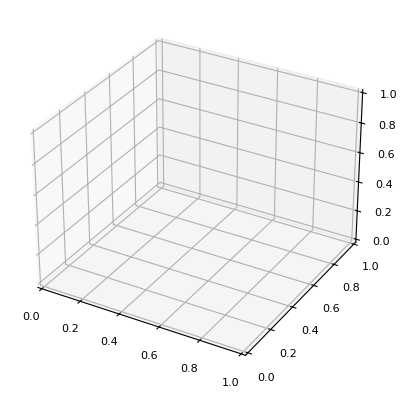

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_reduced3d[:,0], X_reduced3d[:,1], X_reduced3d[:,2], c = [y_test])
#nothing obvious in 3d scatter of PCA
plt.title('UMAP - scaled 3d')
plt.show()

In [41]:
predictions = reg.predict(X_test)
# plt.scatter(list(range(len(y_test))), y_test, c = 'b', label = 'Actual peak2trough')
# plt.scatter(list(range(len(y_test))), predictions, c = 'r', label = 'Predicted peak2trough')
# # plt.legend()
# plt.show()

plt.scatter(y_test, predictions, c = 'r', label='prediction')
plt.plot(y_test, y_test, c='b', label = 'ideal')
# plt.plot(list(range(len(y_test)), predictions,color='k')
plt.legend()
plt.title('LR prediction of P2T from Embeddings')
plt.xlabel('Actual Peak to Trough Amplitude')
plt.ylabel('Predicted Peak to Trough Amplitude')
plt.text(0, 0.65,'R2 = ~0.65')
plt.show()

ValueError: X has 1 features, but LinearRegression is expecting 5 features as input.

In [42]:
print(y_test.shape, predictions.shape)

NameError: name 'predictions' is not defined

In [167]:
#number of cluster
len(dataframe_cells.cluster_id)

795

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

num_clust = 13

labels = []
aic_scores = []
bic_scores = []
for num_clust in np.arange(795)+1:
    gmm = GaussianMixture(num_clust, random_state=0).fit(X)
    gmm_labels = gmm.predict(X)
    bic_score = gmm.bic(X)
    aic_score = gmm.aic(X)
    labels.append(gmm_labels)
    bic_scores.append(bic_score)
    aic_scores.append(aic_score)

    

In [ ]:
f, arr = plt.subplots()
f.set_size_inches(3., 2.)
arr.plot(np.arange(10) + 1, bic_scores,c='k', marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)

In [165]:
#TODO:
    # brain locs - han code
    # localization     
    #train a model to predict waveform from embeddings, then interpret

In [ ]:
# plt.scatter(X_train, y_train)
# plt.plot(X_train, reg.predict(X_train),color='k')

In [ ]:
print(reg.predict([X_test[9]]))
print(y_test[0])

In [ ]:
from dartsort.localize import localize_torch as localize

In [ ]:
localizations = localize_amplitude_vectors(spike_waveforms

In [ ]:
print(spike_waveforms.shape) #spike, time, channel
data.shape

In [ ]:
data[0].shape

In [ ]:
# normalize_wf(data[0])

In [ ]:
spike_waveforms[0][None,:].shape #look up None vs zero when indexing arrays...

In [ ]:
import einops

In [ ]:
print(spikes.shape)
spike_data = np.array([neuron[0, :] for neuron in spikes])
print(spike_data.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.eventplot(spike_times[0:50])
plt.show()

In [ ]:
spike_loader = SpikeSortingLoader(pid=pid, one=one)

In [ ]:
# Download and load data
spikes, clusters, channels = spike_loader.load_spike_sorting()

# Assign brain location information from channels to clusters
# clusters = spike_loader.merge_clusters(spikes, clusters, channels)

In [ ]:
clusters

In [ ]:
import dartsort

In [ ]:
clusters.keys()